In [51]:
# Imports
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import subprocess
from IPython.core.debugger import set_trace
from math import log


# Export notebook as python script to the ../python-code - folder

In [5]:
subprocess.run("jupyter nbcbonvert --output-dir='../python-code' --to python Graphics.ipynb --TemplateExporter.exclude_markdown=True --TemplateExporter.exclude_input_prompt=True", shell=True)

CompletedProcess(args="jupyter nbcbonvert --output-dir='../python-code' --to python Graphics.ipynb --TemplateExporter.exclude_markdown=True --TemplateExporter.exclude_input_prompt=True", returncode=1)

# Create plots for training and test data T1 -> T2

In [52]:
plt.style.available
plt.style.use("ggplot")

In [81]:
def create_plot(timepoint:str="T1_T2", mode:str="train", is_task_conviction:bool=True, task:str="Conviction", global_distribution:bool=True, size:tuple=(20,20), normalize_values:bool=True, **kwargs) -> None:
    """
    Create plot of rating distribution.

    Params:
        timepoint (str, optional): The point in time for which the plot is created. Defaults to "T1_T2".
        mode(str, optional): The mode for which the data should be processed. Can either be "train" or "test". Defaults to "train".
        is_task_conviction (bool, optional): Specify for which task the plot is created. If True it is created for conviction task. If False it is created for the weight task. Defaults to True.
        global_distribution(bool, optional): If set to True, the overall distribution of values for the timpoint is plotted as a bar plot. If set to False the stacked rating counts for each item is plotted. Defaults to True.
        size (tuple, optional): Specify the size of the plot.
    """
    path = f"../../data/{timepoint}/{mode}.csv"
    df = pd.read_csv(path)
    df.drop("username", axis=1, inplace=True)
    if is_task_conviction:
        df = df[[f"statement_attitude_{i}" for i in [j for j in range(324,400) if j != 397]]]
        value_range = (0,1)
    else:
        df = df[[f"argument_rating_{i}" for i in [j for j in range(324,400) if j != 397]]]
        value_range = (0,1,2,3,4,5,6)
    
    fig, ax = plt.subplots()
        
    if global_distribution:
        # Produce bar plots of the overall value distribution
        unique_values, counts_values = np.unique(df.values, return_counts=True)
        # Exclude last value as it is nan
        unique_values = unique_values[:-1].astype(int)
        counts_values = counts_values[:-1].astype(int)
        plt.bar(unique_values, counts_values, tick_label=unique_values)
        if is_task_conviction:
            plt.title(f"Distribution of Conviction Values for {timepoint}");
            plt.xlabel("Conviction Rating Values")
        else:
            plt.title(f"Distribution of Weight Values for {timepoint}")
            plt.xlabel("Weight Rating Values")
        plt.rcParams["figure.figsize"] = size
        plt.ylabel(ylabel="# Ratings");
    
    else:
        # Produce bar plot of the value counts of all items
        value_counts = np.array([np.unique(df[c], return_counts=True) for c in df.columns])
        arg_ids = [i for i in range(len(df.columns))]
        for v in value_counts:
            i = 0
            for value in value_range:
                if value not in v[0]:
                    v[0] = np.insert(v[0], i, float(value)) 
                    v[1] = np.insert(v[1], i, 0)
                i += 1
            i = 0 
        # Zip value counts and ids together to filter out the items without ratings
        value_counts = list(map(lambda x: (x[0][:-1], x[1][:-1]) if len(x[1]) != len(value_range) else x, value_counts))
        zipped = list(zip(arg_ids, value_counts))
        # Filter out all items without ratings
        zipped = list(filter(lambda x: len(x[1][0]) > 0, zipped))
        arg_ids, value_counts = list(zip(*zipped))
        # Get only the counts
        value_counts = map(lambda x: x[1], value_counts)
        if normalize_values:
            value_counts =list(map(lambda x: x / sum(x), value_counts))
            # Map to percentage
            value_counts = list(map(lambda x: x * 100, value_counts))
        # Create tuples of counts for specific values for each item
        item_value_counts = list(zip(*value_counts))
        first_bar = True
        summarize = False
        if (not is_task_conviction and not global_distribution):
            first = np.sum(item_value_counts[0:3], axis=0)
            second = np.sum(item_value_counts[3:], axis=0)
            item_value_counts = np.array([first, second])
            summarize = True
        for i in range(len(item_value_counts)):
            if first_bar:
                if summarize:
                    ax.bar(arg_ids, item_value_counts[i], label="0 - 3")
                else:
                    ax.bar(arg_ids, item_value_counts[i], label=str(i))
            else:
                bottom = np.array([sum(x) for x in zip(*item_value_counts[:i])])
                if summarize:
                    ax.bar(arg_ids, item_value_counts[i], label="4 - 6", bottom=bottom)
                else:
                    ax.bar(arg_ids, item_value_counts[i], label=str(i), bottom=bottom)
            first_bar = False
        plt.rcParams["figure.figsize"] = size
        ax.legend(loc="upper left", bbox_to_anchor=(0.71, 1), ncol=2, prop={"size":20})
        plt.xlabel("Argument Index")
        plt.ylabel("Percentage of Ratings")
        plt.rcParams["font.size"] = 20
        plt.savefig(fname=f"../../ba_thesis/images/{timepoint}_{mode}_{task}.jpg")
        return plt.figure()

C:\Users\Rico\AppData\Local\Temp/ipykernel_6544/2750425354.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value_counts = np.array([np.unique(df[c], return_counts=True) for c in df.columns])
C:\Users\Rico\AppData\Local\Temp/ipykernel_6544/2750425354.py:61: RuntimeWarning: invalid value encountered in true_divide
  value_counts =list(map(lambda x: x / sum(x), value_counts))


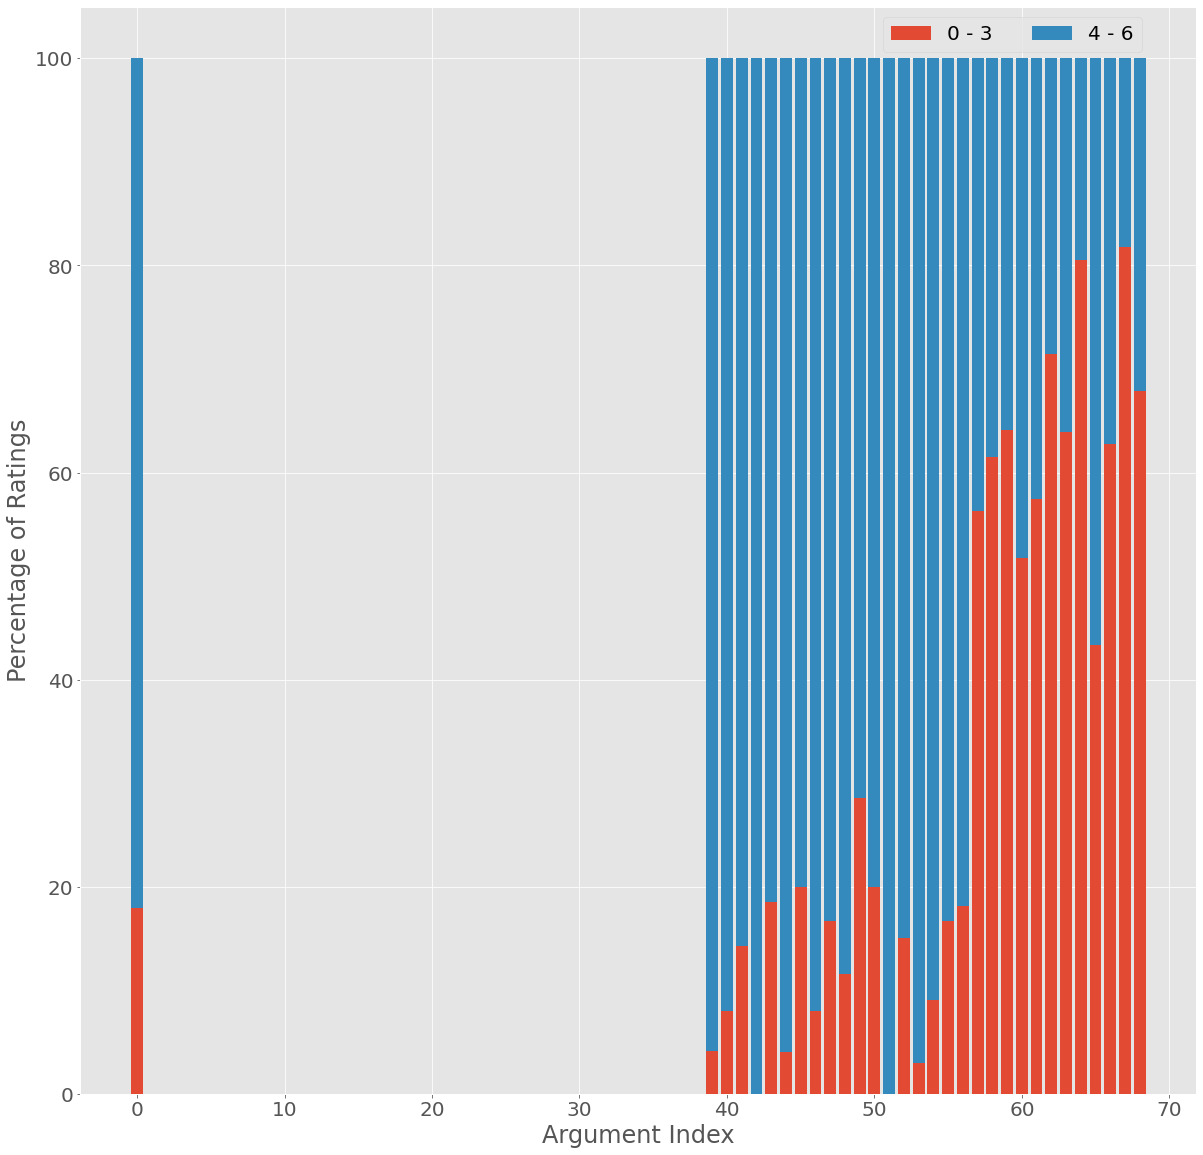

<Figure size 1440x1440 with 0 Axes>

In [84]:
x = create_plot(timepoint="T1_T2", mode="test", is_task_conviction=False, task="Weight", global_distribution=False, size=(20,20))

In [101]:
def compute_Shannon_Entropy(timepoint="T1_T2", mode="train", task="conviction") -> float:
    """
    Compute the Shannon Entropy of a dataset to measure the balance of the distribution of ratings.

    Args:
        timepoint (str, optional): The timepoint in which the dataset resides. Defaults to "T1_T2".
        mode (str, optional): The mode of the dataset. Can be either "train", "validation" or "test. Defaults to "train".
        task (str, optional): The task for which the dataset is used. Can be "conviction" or "weight". Defaults to "conviction".
    Returns:
        float: A measure of balance for the dataset. 0 means no balance and 1 means totally balanced.
    """
    path = f"../../data/{timepoint}/{mode}.csv"
    df = pd.read_csv(path)
    # Depending on the task, choose the corresponding columns
    if task == "conviction":
        df = df[[f"statement_attitude_{i}" for i in [j for j in range(324,400) if j != 397]]] 
        # Number of possible discrete rating values in this task
        M = 2
    else:
        df = df[[f"argument_rating_{i}" for i in [j for j in range(324,400) if j != 397]]]
        # Number of possible discrete rating values in this task
        M = 7
    # Number of instances
    N = len(df)
    # Number of columns(subtract the username column)
    C = len(df.columns)
    # Number of all cells in the dataset that are not na
    num_all_non_na_cells = C*N - df.isna().values.sum()
   # num_all_non_na_cells = C*N
    # Compute Shannon Entropy
    nominator = 0.0
    values, counts = np.unique(df.values, return_counts=True)
    # Only get actual values, not the nan - values
    values = values[:M]
    counts = counts[:M]
    for i, c in enumerate(counts):
        rating_ratio = (c / num_all_non_na_cells)
        nominator += ( rating_ratio * log(rating_ratio) )
    
    return (-nominator / log(M))

In [4]:
class metric_helper():
    
    def __init__(self, trues:np.array, preds:np.array, task:str="Conviction", *metrics:str):
        self.trues_ = trues
        self.preds_ = preds
        self.task_ = task
        self.metrics = metrics
        self.classes = (0, 1) if task == "Conviction" else (0,1,2,3,4,5,6)
        
    def compute_average_metrics(self) -> dict:
        """
        Calculate the metrics' average over all classes

        Returns:
            dict: Dictionary containing the metric name as key and its averaged value as value.
        """
        metrics_per_class = self.compute_metrics_per_class()
        # metrics averages over all classes with equal weight per class
        metrics_averaged = {}
    
    def compute_metrics_per_class(self) -> dict:
        """
        Compute the metrics Recall, Precision, F1-Score, G-Mean per class. 

        Params:
            trues (np.array): True values
            preds (np.array): predictions.
            task (str, optional): The task for which the metrics per class need to be computed. Defaults to "Conviction".
            *metrics: Metrics to compute. Can be one of the following: 'precision', 'recall', 'f1', 'gmean'.

        Returns:
            dict: Dictionary containing a class label as key and a dictionary with the metric name as key and its value as value.
        """
        # Compute tuples of (metric_name, metric_value)
        metric_values = [(m, getattr(self, f"compute_{m}")(self.trues, self.preds)) for m in self.metrics]
        # Compute dictionary with metric values per class
        metrics_per_class = {c : {m[0] : m[1][c] for m in metric_values} for c in self.classes}
        
        return metrics_per_class
     
    def compute_precision(self, trues, preds) -> dict:
        """
        Calculate the precision metric for the given true and prediction values.

        Params:
            trues (np.array): [description]
            preds (np.array): [description]
            
        Returns:
            dict: A dictionary containing the classes as key and the precision value for this class as value. 
        """
        combined = np.array(list(zip(trues, preds)))
        precision = {c:None for c in self.classes}
        for c in precision:
            tp = np.sum((combined[i][0] == c) and (combined[i][1] == c) for i in range(len(combined)))
            fp = np.sum((combined[i][0] != c) and (combined[i][1] == c) for i in range(len(combined)))
            precision[c] = tp / (tp + fp)
        
        return precision
    
    def compute_recall(self, trues, preds) -> dict:
        """
        Calculate the recall metric for the given true and prediction values.

        Params:
            trues (np.array): [description]
            preds (np.array): [description]
            
        Returns:
            dict: A dictionary containing the classes as key and the recall value for this class as value. 
        """
        combined = np.array(list(zip(trues, preds)))
        recall = {c:None for c in self.classes}
        for c in recall:
            tp = np.sum((combined[i][0] == c) and (combined[i][1] == c) for i in range(len(combined)))
            fn = np.sum((combined[i][0] == c) and (combined[i][1] != c) for i in range(len(combined)))
            recall[c] = tp / (tp + fn)
        
        return recall

    def compute_f1(self, trues:np.array, preds:np.array, beta:float=1.0) -> dict:
        """
        Calculate the precision metric for the given true and prediction values.

        Params:
            trues (np.array): [description]
            preds (np.array): [description]
            
        Returns:
            dict: A dictionary containing the classes as key and the f1 value for this class as value. 
        """
        assert beta >= 0, "beta needs to be non-negative."
        combined = np.array(list(zip(trues, preds)))
        f1 = {c:None for c in self.classes}
        for c in f1:
            score = ((1 + beta)**2 * recall * precision) / (beta**2 * recall + precision)
            f1[c] = score
        
        return f1
    
    def compute_gmean(self,trues, preds) -> dict:
        """
        Calculate the precision metric for the given true and prediction values.

        Params:
            trues (np.array): [description]
            preds (np.array): [description]
            
        Returns:
            dict: A dictionary containing the classes as key and the gmean value for this class as value. 
        """
        combined = np.array(list(zip(trues, preds)))
        gmean = {c:None for c in self.classes}
        for c in gmean:
            tp = np.sum((combined[i][0] == c) and (combined[i][1] == c) for i in range(len(combined)))
            fn = np.sum((combined[i][0] == c) and (combined[i][1] != c) for i in range(len(combined))) 
            fp = np.sum((combined[i][0] != c) and (combined[i][1] == c) for i in range(len(combined))) 
            tn = np.sum((combined[i][0] != c) and (combined[i][1] != c) for i in range(len(combined)))
            gmean[c] = np.sqrt((tp / (tp + fn)) * (tn/(tn+fp)))
            
        return gmean
